<a href="https://colab.research.google.com/github/pesfahanian/Kaggle_Pneumonia_InceptionV3/blob/main/Kaggle_Pneumonia_InceptionV3_Version3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Pneumonia/chest_xray

/content/drive/MyDrive/Pneumonia/chest_xray


In [2]:
!ls

EfficientNet2.h5  foo.pdf	  __MACOSX	  pneumonia.h5	train
EfficientNet.h5   InceptionV3.h5  model_vgg16.h5  test		val


In [15]:
import glob
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from itertools import cycle

from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import keras_preprocessing
from keras.models import load_model
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

In [4]:
train_path      =   '/content/drive/MyDrive/Pneumonia/chest_xray/train'
validation_path =   '/content/drive/MyDrive/Pneumonia/chest_xray/val'
test_path       =   '/content/drive/MyDrive/Pneumonia/chest_xray/test'

In [5]:
train_NORMAL = len(glob.glob(train_path + '/NORMAL/*'))
train_PNEUMONIA = len(glob.glob(train_path + '/PNEUMONIA/*'))

validation_NORMAL = len(glob.glob(validation_path + '/NORMAL/*'))
validation_PNEUMONIA = len(glob.glob(validation_path + '/PNEUMONIA/*'))

test_NORMAL = len(glob.glob(test_path + '/NORMAL/*'))
test_PNEUMONIA = len(glob.glob(test_path + '/PNEUMONIA/*'))

print('Train:', train_NORMAL, 'NORMAL,', train_PNEUMONIA, 'PNEUMONIA.')
print('Validation:', validation_NORMAL, 'NORMAL,', validation_PNEUMONIA, 'PNEUMONIA.')
print('Test:', test_NORMAL, 'NORMAL,', test_PNEUMONIA, 'PNEUMONIA.')

Train: 1300 NORMAL, 3834 PNEUMONIA.
Validation: 49 NORMAL, 49 PNEUMONIA.
Test: 234 NORMAL, 390 PNEUMONIA.


In [6]:
IMG_SIZE    =   224
num_classes =   2
epochs      =   15
batch_size  =   16

In [7]:
train_datagen = ImageDataGenerator(rescale          =   1./255,
                                   rotation_range   =   15,     # changed this
                                   shear_range      =   0.2,    # changed this
                                   zoom_range       =   0.2,    # changed this
                                   horizontal_flip  =   False)
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size =   (IMG_SIZE, IMG_SIZE),
                                                    class_mode  =   'categorical',
                                                    batch_size  =   batch_size,
                                                    shuffle     =   True)

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                              target_size =   (IMG_SIZE, IMG_SIZE),
                                                              class_mode  =   'categorical',
                                                              batch_size  =   batch_size,
                                                              shuffle     =   False)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size =   (IMG_SIZE, IMG_SIZE),
                                                  class_mode  =   'categorical',
                                                  batch_size  =   batch_size,
                                                  shuffle     =   False)

Found 5134 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


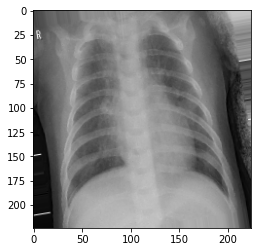

In [8]:
x, y = train_generator.next()
for i in range(0, 1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [9]:
URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4' 
feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224, 3))
feature_extractor.trainable = False

In [10]:
model = tf.keras.models.Sequential(
    [
     feature_extractor,
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(num_classes, activation='softmax')
    ]
)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 21,938,210
Trainable params: 135,426
Non-trainable params: 21,802,784
______________________________________

In [12]:
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

In [29]:
save_path = "InceptionV3-(2).h5"
checkpoint = ModelCheckpoint(save_path,
                             monitor        =   'val_accuracy',
                             verbose        =   1,
                             save_best_only =   True,
                             mode           =   'max')
callbacks = [checkpoint]

In [30]:
cw = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)
class_weights = {0: cw[0], 1: cw[1]}
print(class_weights) 

{0: 1.9746153846153847, 1: 0.6695357329160146}


In [31]:
model.compile(optimizer =   tf.optimizers.Adam(learning_rate=0.0001),
              loss      =   'binary_crossentropy',  # changed this
              metrics   =   METRICS )

In [32]:
history = model.fit(train_generator,
                    epochs              =   epochs,
                    callbacks           =   [callbacks],
                    validation_data     =   validation_generator,
                    class_weight        =   class_weights,
                    use_multiprocessing =   True,
                    workers             =   4)

Epoch 1/15


320/321 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9312 - precision: 0.9232 - recall: 0.9232WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00001: val_accuracy improved from -inf to 0.91837, saving model to InceptionV3-(2).h5
321/321 [==============================] - 99s 309ms/step - loss: 0.1660 - accuracy: 0.9312 - precision: 0.9232 - recall: 0.9232 - val_loss: 0.2182 - val_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 2/15


321/321 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00002: val_accuracy did not improve from 0.91837
321/321 [==============================] - 95s 295ms/step - loss: 0.1692 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - val_loss: 0.2075 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 3/15


320/321 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00003: val_accuracy did not improve from 0.91837
321/321 [==============================] - 96s 300ms/step - loss: 0.1634 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - val_loss: 0.2049 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 4/15


320/321 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00004: val_accuracy did not improve from 0.91837
321/321 [==============================] - 96s 300ms/step - loss: 0.1619 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - val_loss: 0.1977 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 5/15


321/321 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00005: val_accuracy did not improve from 0.91837
321/321 [==============================] - 97s 302ms/step - loss: 0.1570 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - val_loss: 0.2231 - val_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 6/15


320/321 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00006: val_accuracy did not improve from 0.91837
321/321 [==============================] - 97s 302ms/step - loss: 0.1644 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - val_loss: 0.2094 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 7/15


321/321 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359


Epoch 00007: val_accuracy did not improve from 0.91837
321/321 [==============================] - 95s 297ms/step - loss: 0.1662 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - val_loss: 0.2207 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 8/15


320/321 [============================>.] - ETA: 0s - loss: 0.1560 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00008: val_accuracy did not improve from 0.91837
321/321 [==============================] - 93s 291ms/step - loss: 0.1561 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - val_loss: 0.2203 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 9/15


320/321 [============================>.] - ETA: 0s - loss: 0.1522 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00009: val_accuracy did not improve from 0.91837
321/321 [==============================] - 92s 287ms/step - loss: 0.1519 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - val_loss: 0.2102 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 10/15


321/321 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00010: val_accuracy did not improve from 0.91837
321/321 [==============================] - 92s 287ms/step - loss: 0.1528 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - val_loss: 0.2226 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 11/15


321/321 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00011: val_accuracy did not improve from 0.91837
321/321 [==============================] - 92s 286ms/step - loss: 0.1455 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - val_loss: 0.1926 - val_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 12/15


321/321 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00012: val_accuracy did not improve from 0.91837
321/321 [==============================] - 91s 283ms/step - loss: 0.1510 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - val_loss: 0.1975 - val_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 13/15


320/321 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00013: val_accuracy did not improve from 0.91837
321/321 [==============================] - 92s 286ms/step - loss: 0.1504 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - val_loss: 0.2095 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 14/15


321/321 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00014: val_accuracy did not improve from 0.91837
321/321 [==============================] - 91s 284ms/step - loss: 0.1416 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - val_loss: 0.1900 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 15/15


320/321 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00015: val_accuracy did not improve from 0.91837
321/321 [==============================] - 91s 284ms/step - loss: 0.1461 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - val_loss: 0.2213 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082


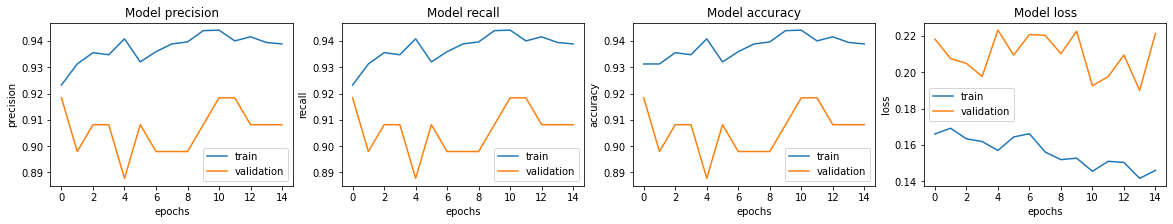

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'validation'])

In [34]:
model.evaluate(test_generator)

39/39 [==============================] - 6s 161ms/step - loss: 0.3494 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702


[0.34940627217292786, 0.870192289352417, 0.870192289352417, 0.870192289352417]

In [35]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [36]:
print('Classification Report:')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.73      0.81       234
   PNEUMONIA       0.86      0.95      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.86       624
weighted avg       0.87      0.87      0.87       624



In [37]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize =   False,
                          title     =   'Confusion matrix',
                          cmap      =   plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90, va="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize = 15,
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


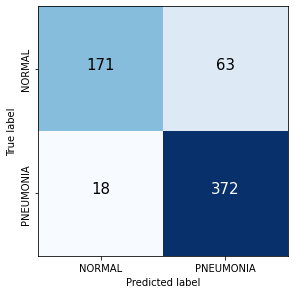

In [38]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')